# Forensic Intelligence Applications
In this section we will explore the use of __similar source, score-based, non-anchored LRs__ for forensic intelligence applications. Score-based LRs can be a valuable tool for relating forensic traces to each other in a manner that pertains to:

* The relative __rarity__ of a relationship between two traces
* The different __senses__ of similarity and thier expression in terms of multivariable features

We will explore the use of __likelihood ratios__ as a method for exploring the __connectivity__ between forensic traces. As well as the interactive process of asking different kinds of forensic questions and interpretting the results.

## How to work with the Jupyter notebook interface
Each cell contains some code that is executed when you select any cell and:
<br />
<center>click on the __execute__ icon<br />
OR<br />
presses <code>CRTL + ENTER</code><br />
</center>
<br />
In between these code cells are text cells that give explanations about the input and output of these cells as well as information about the operations being performed.

In [15]:
## importing nice things
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from numpy import ndarray
import random
from matplotlib.mlab import PCA as mlabPCA
import matplotlib.mlab as mlab
from scipy.stats import norm
import networkx as nx
from scipy.spatial.distance import pdist, cdist, squareform

### Define some characteristics of the dataset for our example

In [16]:
NUMBER_OF_CLASSES = 10 
# number of different classes 
SAMPLES_PER_CLASS = 100 
# we assume balanced classes
NOISINESS_INTRA_CLASS = 0.25 
#expresses the spread of the classes (between 0.0 and 1.0 gives workable data)
NOISINESS_INTER_CLASS = 4.5 
# expresses the spaces in between the clases (between 5 and 10 times the value of NOISINESS_INTRA_CLASS is nice)
DIMENSIONALITY = 10 
# how many features are measured for this multivariate data
FAKE_DIMENSIONS = 2 # these features are drawn from a different (non class specific distribution) so as to have no actual class descriminating power.

if NUMBER_OF_CLASSES * SAMPLES_PER_CLASS > 10000:
    print 'Too many samples requested, please limit simulated data to 10000 samples to avoid slowing down the server kernel... Using Default values'
    print NUMBER_OF_CLASSES

In [3]:
##simulate interesting multiclass data 
myData = np.empty((0,DIMENSIONALITY), int)
nonInformativeFeats = np.array(random.sample(range(DIMENSIONALITY), FAKE_DIMENSIONS))

labels =  np.repeat(range(NUMBER_OF_CLASSES), SAMPLES_PER_CLASS) # integer class labels
#print labels

for x in range(0, NUMBER_OF_CLASSES):
    A = np.random.rand(DIMENSIONALITY,DIMENSIONALITY)
    cov = np.dot(A,A.transpose())*NOISINESS_INTRA_CLASS # ensure a positive semi-definite covariance matrix, but random relation between variables
    mean = np.random.uniform(-NOISINESS_INTER_CLASS, NOISINESS_INTER_CLASS, DIMENSIONALITY) # random n-dimensional mean in a space we can plot easily
    #print 'random mutlivariate distribution mean for today is', mean
    #print 'random positive semi-define matrix for today is', cov

    x = np.random.multivariate_normal(mean,cov,SAMPLES_PER_CLASS)
    myData = np.append(myData,  np.array(x), axis=0)
    # exit here and concatenate

x = np.random.multivariate_normal(np.zeros(FAKE_DIMENSIONS),mlab.identity(FAKE_DIMENSIONS),SAMPLES_PER_CLASS*NUMBER_OF_CLASSES)
myData[:, nonInformativeFeats.astype(int)] = x
# substitute the noninformative dimensions with smaples drawn from the sampe boring distribution
    
#print myData    

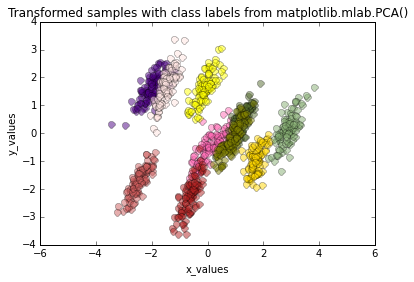

In [4]:
## plotting our dataset to see if it is what we expect
names = matplotlib.colors.cnames #colours for plotting
names_temp = names

col_means = myData.mean(axis=0,keepdims=True)
myData = myData - col_means # mean center the data before PCA

col_stds = myData.std(axis=0,keepdims=True)
myData = myData / col_stds # unit variance scaling 

results = mlabPCA(myData)# PCA results into and ND array scores, loadings
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
ax.axis('equal');
for i in range(NUMBER_OF_CLASSES):
    plt.plot(results.Y[labels==i,0],results.Y[labels==i,1], 'o', markersize=7, color=names_temp.popitem()[1], alpha=0.5)
# plot the classes after PCA just for rough idea of their overlap.

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title('Transformed samples with class labels from matplotlib.mlab.PCA()')
    
plt.show()

In [5]:
DISTANCE_METRIC = 'canberra'
# this can be any of: euclidean, minkowski, cityblock, seuclidean, sqeuclidean, cosine, correlation
# hamming, jaccard, chebyshev, canberra, braycurtis, mahalanobis, yule
DISTRIBUTION = 'normal'
HOLDOUT_SIZE = 0.01

(990, 10) is the size of the data used to model same-source and different-source distributions
(10, 10) are the points we will evaluate to see LRs achieved


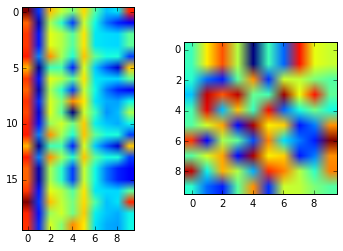

In [6]:
# divide the dataset
idx = np.random.choice(np.arange(NUMBER_OF_CLASSES*SAMPLES_PER_CLASS), int(NUMBER_OF_CLASSES*SAMPLES_PER_CLASS*HOLDOUT_SIZE), replace=False)
#10% holdout set removed to demonstrate the LR values of new samples!

test_samples = myData[idx,:]
test_labels = labels[idx]

train_samples = np.delete(myData, idx, 0)
train_labels = np.delete(labels, idx)

print train_samples.shape, 'is the size of the data used to model same-source and different-source distributions'
print test_samples.shape, 'are the points we will evaluate to see LRs achieved'

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(train_samples[np.random.randint(DIMENSIONALITY,size=DIMENSIONALITY*2),:])
axes[1].imshow(test_samples[np.random.randint(test_samples.shape[0],size=test_samples.shape[0]),:])
plt.show()

In [7]:
# optional feature selection/masking for different questions

same source comparisons made:  48511
diff source comparisons made:  882088


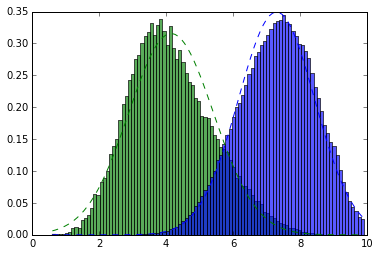

In [8]:
#Pairwise distance calculations are going in here
same_dists = np.empty((0,1))
diff_dists = np.empty((0,1))

for labInstance in np.unique(train_labels):
    dists = pdist(train_samples[train_labels==labInstance,:],DISTANCE_METRIC)
    # this is already the condensed-form (lower triangle) with no duplicate comparisons.
    same_dists = np.append(same_dists, np.array(dists))
    del dists
        
    dists = cdist(train_samples[train_labels==labInstance,:], train_samples[train_labels!=labInstance,:], DISTANCE_METRIC)
    #print dists.shape
    train_samples[train_labels!=labInstance,:]
    diff_dists = np.append(diff_dists, np.array(dists).flatten())
#print same_dists.shape
#print diff_dists.shape

minval = min(np.min(diff_dists),np.min(same_dists))
maxval = max(np.max(diff_dists),np.max(same_dists))

# plot the histograms to see difference in distributions
# Same source data 
mu_s, std_s = norm.fit(same_dists) # fit the intensities wth a normal
plt.hist(same_dists, np.arange(minval, maxval, abs(minval-maxval)/100), normed=1, facecolor='green', alpha=0.65)
y_same = mlab.normpdf(np.arange(minval, maxval, abs(minval-maxval)/100), mu_s, std_s) # estimate the pdf over the plot range
l=plt.plot(np.arange(minval, maxval, abs(minval-maxval)/100), y_same, 'g--', linewidth=1)

# Different source data
mu_d, std_d = norm.fit(diff_dists) # fit the intensities wth a normal
plt.hist(diff_dists, np.arange(minval, maxval, abs(minval-maxval)/100), normed=1, facecolor='blue', alpha=0.65)
y_diff = mlab.normpdf(np.arange(minval, maxval, abs(minval-maxval)/100), mu_d, std_d) # estimate the pdf over the plot range
l=plt.plot(np.arange(minval, maxval, abs(minval-maxval)/100), y_diff, 'b--', linewidth=1)

print 'same source comparisons made: ', same_dists.shape[0]
print 'diff source comparisons made: ', diff_dists.shape[0]

 mu same:  4.14924410383  std same:  1.26398004516
 mu diff:  7.29717802818  std diff:  1.14177627083


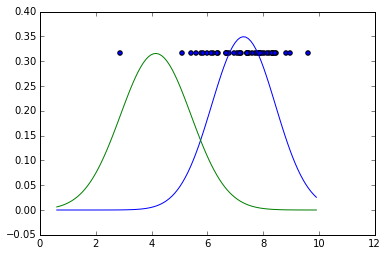

In [9]:
print ' mu same: ', mu_s, ' std same: ', std_s
print ' mu diff: ', mu_d, ' std diff: ', std_d

newDists = squareform(pdist((test_samples),DISTANCE_METRIC)) # new samples (unknown group memebership)
l=plt.plot(np.arange(minval, maxval, abs(minval-maxval)/100), y_diff, 'b-', linewidth=1)
l=plt.plot(np.arange(minval, maxval, abs(minval-maxval)/100), y_same, 'g-', linewidth=1)

l=plt.scatter(squareform(newDists), np.ones(squareform(newDists).shape[0], dtype=np.int)*max(y_same))
# plot the new distances compared to the distributions

lr_holder = [];

for element in squareform(newDists):
    value = mlab.normpdf(element, mu_s, std_s)/mlab.normpdf(element, mu_d, std_d)
    lr_holder.append(value)
    #print value

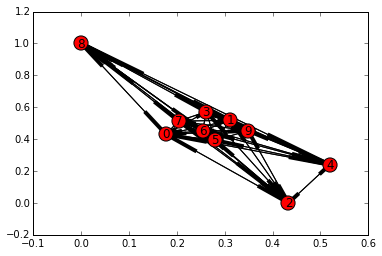

In [10]:
# Plot just the distance based graph

#G=nx.from_numpy_matrix(newDists)
G=nx.from_numpy_matrix(newDists,create_using=nx.MultiDiGraph())
G.edges(data=True)
nx.draw_networkx(G, node_size=200, edge_color='k', with_labels=True, linewidths=1)


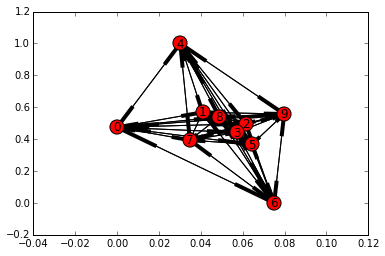

In [11]:
# plot the likelihood based graph
lr_holder = np.true_divide(1,lr_holder)
G2=nx.from_numpy_matrix(squareform(lr_holder),create_using=nx.MultiDiGraph())
G2.edges(data=True)
nx.draw_networkx(G2, node_size=200, edge_color='k', with_labels=True, linewidths=1)